# Risk Premium: Choosing Adequate Discount Rates For Crypto Assets

## 1. Problem definition

"If it is difficult to estimate a reliable historical premium for the US market, it becomes doubly so, when looking at markets with short, volatile and transitional histories. This is clearly true for emerging markets, where equity markets have often been in existence for only short time periods (Eastern Europe, China) or have seen substantial changes over the last few years (Latin America, India)." How about crypto? :)

## 2. Existing approaches in crypto industry

Lack of standardized framework. It appears that there is a certain consensus in the industry of using arbitrary selected 40% discount rate when evaluating crypto assets. 

## 3. TradFi approaches: CAPM Model or WACC model

WACC model is obviously not possible to implement for majority of crypto assets. CAPM model with S&P 500 as a proxy for the market risk premium, also doesn't make much sense as in practice crypto idiosyncratic risk is quite high, beta is often negative and fluctuates significantly from one period to another. 

Below we will show Bitcoin Beta vs S&P 500.



## 4. Proposing a framework for crypto assets - Relative standard deviation

"There are some analysts who believe that the equity risk premiums of markets
should reflect the differences in equity risk, as measured by the volatilities of these markets.
A conventional measure of equity risk is the standard deviation in stock prices; higher
standard deviations are generally associated with more risk. If you scale the standard deviation of one market against another, you obtain a measure of relative risk."

Assuming linear relationship between risk premium and standard deviation we calculate risk premium for asset x as: 

risk_premium(x) = risk_premium(s&p) * stdev(x)/stdev(s&p)

### Obstacles with the model 
- survivor bias in S&P 500 overestimating risk premium 
- two assets may have same standard deviation but different skew and kurtosis 
- Since equity market volatility is affected by liquidity, with more liquid markets often showing higher
volatility, this approach will understate premiums for illiquid markets and overstate the
premiums for liquid markets. Thus, it may be wise to use the model for crypto assets that are considered relatively mature and liquid.

### Ideas for further improving calculations
-  To avoid this bias add another standardized parameter to reflect market liquidity e.g. market_cap / trading volume of asset x vs average market_cap / trading volume for the top 100 crypto assets.
- Make formula sensitive to skew and kurtosis 

## 5. Building the intuition; Other factors that need to be considered 
### Factors lowering risk premium:
- less professional investment audience, larger participation from retail -> lower risk premium 
- younger audience -> lower risk premium [Bakshi, G. S., and Z. Chen, 1994, Baby Boom, Population Aging, and Capital Markets, The Journal of Business, LXVII, 165-202.]
- low savings rate -> lower risk premiums [https://deliverypdf.ssrn.com/delivery.php?ID=739098086122105025069117000097119011123049028029039027085071072111098107126096118094055034030123018059015112065096071097086115038013054059039029117110064089029059022000119091119095024096101027015092026092102103086098125086003110028103024110095002&EXT=pdf&INDEX=TRUE]
- predictability - e.g. BTC monetary policy will be the same 20 years from now (ETH not on the other hand may not)

### Factors increasing risk premium:
- larger uncertainty (geopolitical, regulatory, etc.) | fat tails, low kurtosis
- lower quality of information, information overload, less trust in protocols e.g. rug pulls, insider trading, etc.
- higher volatility of earning (e.g. volatile trading volume for DEXs) 
- illiquidity of the token
- "Myopic loss aversion refers to the finding in behavioral finance that the loss aversion already embedded in individuals becomes more pronounced as the frequency of their monitoring increases. Thus, investors who receive constant updates on equity values actually perceive more risk in equities, leading to higher risk premiums." As passive investing is still not a thing in crypto (e.g. less index funds, ETFs) the risk premiums are higher. However, if we assume more people holding long term regardless of the price and more passive funds entering the market in the future, risk premiums should decrease. 
- Negative skew
- Significant unlock of the new tokens to the market

# Coding

In [1]:
#pip install pandas_datareader

In [2]:
#pip install pycoingecko

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
import matplotlib as mpl
from pandas_datareader.yahoo.daily import YahooDailyReader 
import CoinGeckoFunctions as cgf
from sklearn.linear_model import LinearRegression

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) ## change float at the macro level
plt.rcParams["figure.figsize"] = (14, 6) ## change plot size at the macro level
mpl.rcParams['figure.dpi'] = 300 ## graph resolution

### Importing S&P and crypto price data

In [5]:
stock = ("^GSPC"         
)
start = dt.datetime (2015, 1, 1)
end = dt.datetime.today()  
df_1 = YahooDailyReader (stock, start, end, interval='d').read()
df = df_1['Adj Close']

coin = cgf.get_data_start_to_end('bitcoin', start, end)

In [6]:
index = []
for i in range(len(coin)): 
    index.append(dt.datetime(coin.index[i].year, coin.index[i].month, coin.index[i].day))
    
coin.index = index

### Cleaning data, making sure dates are matching

In [7]:
coin = coin.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
coin = coin.loc[coin.index.isin(list(df.index))]
df = df.loc[df.index.isin(list(coin.index))]

### Lognormal Returns

In [8]:
df_CCR = (np.log(df)-np.log(df.shift(1)))[1:]
coin_CCR = (np.log(coin)-np.log(coin.shift(1)))[1:]

### Time Intervals For Calculating Parameters 
- default at 30 i.e. monthly data

In [9]:
def intervals(interval = 30, start = dt.datetime(2020,1,1), end = dt.datetime.today()):
    
    '''''''''
    interval - default set at 30 implying monthly data.
    '''''''''
    
    num_periods = int((end - start).days / interval)
    
    start = pd.to_datetime(end.date())
    starts = [start]
    for i in range(num_periods):
        starts.append(starts[i] - dt.timedelta(interval))
    
    starts.reverse()
    
    return starts

In [10]:
dates = intervals(30)

## Beta and Correlation Calculation

In [11]:
def calculate_beta(market, crypto, start, end):
    
    x = market[(market.index>=start) * (market.index<end)]
    y = crypto[(crypto.index>=start) * (crypto.index<end)]
    
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y.values)
    
    return model.coef_[0][0]

def beta_TS(market, crypto, dates):
    
    coef = []
    ends = []

    for i in range(len(dates)-1):

        coef.append(calculate_beta(market, crypto, dates[i], dates[i+1]))
        ends.append(dates[i+1])    
        
    return pd.DataFrame(data=coef, index = ends, columns = ['Beta'])

In [12]:
def calculate_corr(market, crypto, start, end):

    x = market[(market.index>=start) * (market.index<end)]
    y = crypto[(crypto.index>=start) * (crypto.index<end)]
    
    return pd.concat([x, y], axis = 1).corr().iloc[0, 1]

def corr_TS (market, crypto, dates):
    
    corr = []
    ends = []

    for i in range(len(dates)-1):

        corr.append(calculate_corr(market, crypto, dates[i], dates[i+1]))
        ends.append(dates[i+1])

    return pd.DataFrame(data=corr, index = ends, columns = ['Correlation'])

In [13]:
def calculate_std(returns, start, end):

    returns = returns[(returns.index>=start) * (returns.index<end)]
    
    return np.std(returns)[0]

def std_TS (returns, dates):
    
    std = []
    ends = []

    for i in range(len(dates)-1):

        std.append(calculate_std(returns, dates[i], dates[i+1]))
        ends.append(dates[i+1])

    return pd.DataFrame(data=std, index = ends, columns = ['Standard Deviation'])

In [14]:
calculate_beta(df_CCR, coin_CCR, dates[0], dates[-1])

-0.1714172753338954

In [15]:
beta = beta_TS(df_CCR, coin_CCR, dates)
corr = corr_TS(df_CCR, coin_CCR, dates)


print ("Table illustrates correlation between S&P 500 and crypto returns, as well as crypto Beta relative to S&P 500")
pd.concat([corr, beta], axis = 1)

Table illustrates correlation between S&P 500 and crypto returns, as well as crypto Beta relative to S&P 500


,Correlation,Beta
2020-02-03,0.1288,0.5489
2020-03-04,0.0635,0.1085
2020-04-03,-0.3482,-0.6688
2020-05-03,0.0393,0.0660
2020-06-02,0.1450,0.5208
2020-07-02,-0.1317,-0.1980
2020-08-01,-0.4744,-1.3930
2020-08-31,-0.4227,-1.8281
2020-09-30,0.1371,0.3046
2020-10-30,-0.1145,-0.1928


## Rolling Average

In [16]:
def corr_rolling(period, data1, data2):
    
    '''''''''
    period - number of days
    '''''''''
    
    corr = []
    date = []

    for i in range(period, len(data1)):
        x = data1[i-period:i]
        y = data2[i-period:i]

        date.append(data1.index[i])    
        corr.append(pd.concat([x,y], axis=1).corr().iloc[0,1])

    return pd.DataFrame(data=corr, index=date, columns=['corr'])   

In [17]:
def beta_rolling(period, data1, data2):
    
    beta = []
    date = []

    for i in range(period, len(data1)):
        x = data1[i-period:i]
        y = data2[i-period:i]
        
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        
        date.append(data1.index[i])    
        beta.append(model.coef_[0][0])
    
    return pd.DataFrame(data=beta, index=date, columns=['beta'])   

In [18]:
corr10 = corr_rolling(10, df_CCR, coin_CCR)
corr30 = corr_rolling(30, df_CCR, coin_CCR)
corr90 = corr_rolling(90, df_CCR, coin_CCR)

In [19]:
beta10 = beta_rolling(10, df_CCR, coin_CCR)
beta30 = beta_rolling(30, df_CCR, coin_CCR)
beta90 = beta_rolling(90, df_CCR, coin_CCR)

In [20]:
def standardize (data, base = 1000):
    
    '''''''''
    data - pd.Series
    '''''''''
    
    data[0] = base
    
    for i in range(len(data)-1):
        data[i+1] = np.exp(data[i+1] + np.log(data[i]))
    
    return data

In [21]:
coin1000 = standardize(coin_CCR.copy()[coin_CCR.index.year>=2022]['bitcoin'])
sp1000 = standardize(df_CCR.copy()[df_CCR.index.year>=2022])
stand = pd.concat([sp1000, coin1000], axis=1)

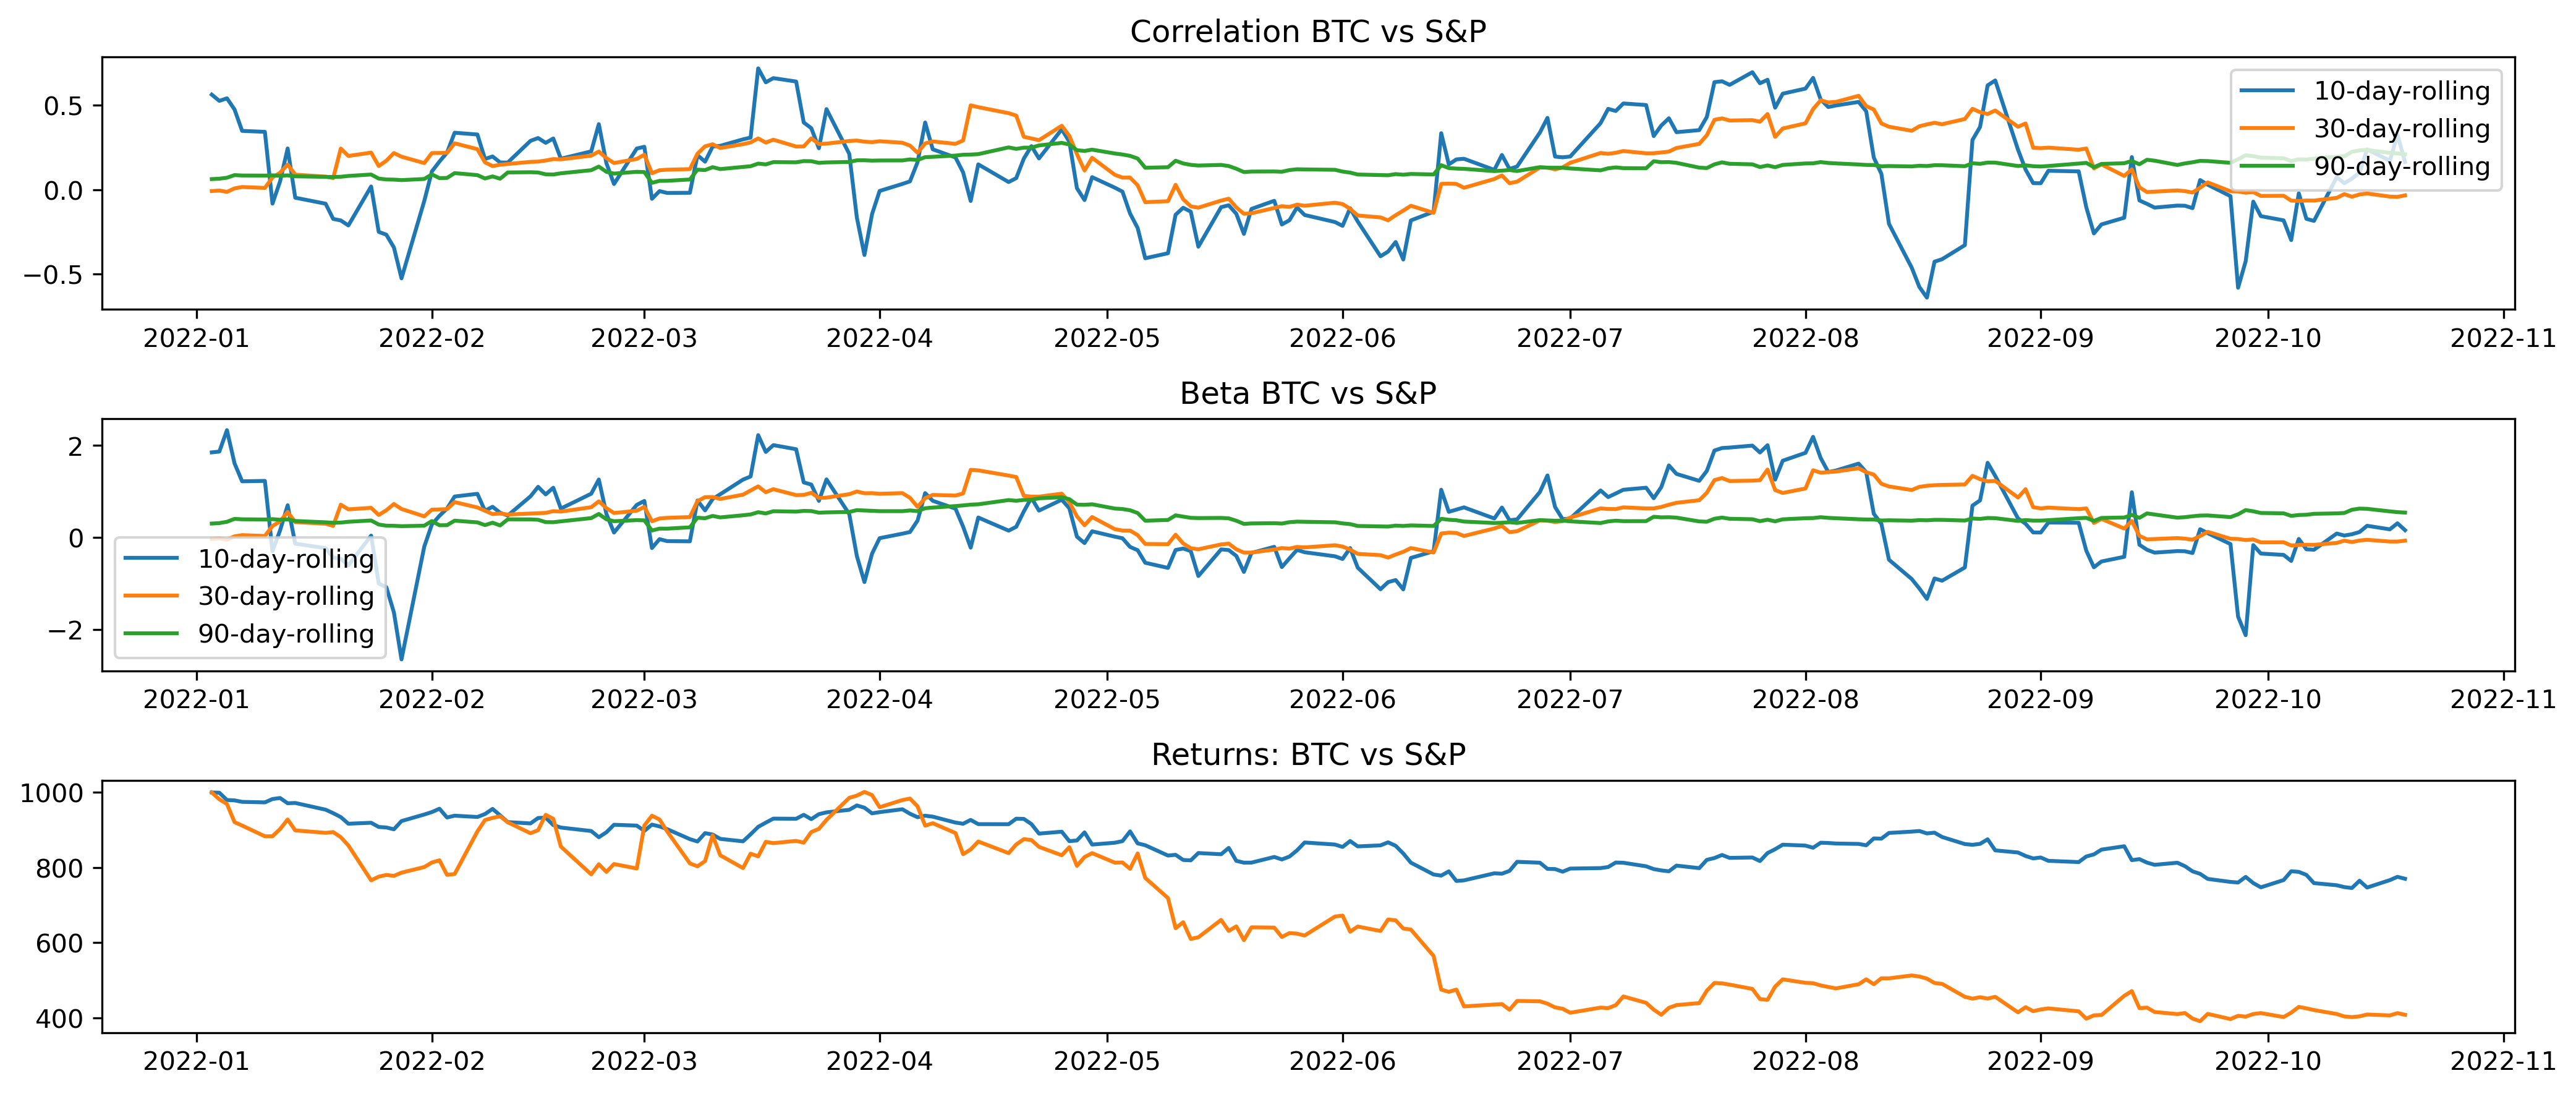

In [22]:
fig, ax = plt.subplots(3, 1)

ax[0].plot(corr10[corr10.index.year>=2022], label = '10-day-rolling')
ax[0].plot(corr30[corr30.index.year>=2022], label = '30-day-rolling')
ax[0].plot(corr90[corr90.index.year>=2022], label = '90-day-rolling')
ax[0].legend()
ax[0].set_title('Correlation BTC vs S&P')

ax[1].plot(beta10[beta10.index.year>=2022], label = '10-day-rolling')
ax[1].plot(beta30[beta30.index.year>=2022], label = '30-day-rolling')
ax[1].plot(beta90[beta90.index.year>=2022], label = '90-day-rolling')
ax[1].legend()
ax[1].set_title('Beta BTC vs S&P')

ax[2].plot(stand, label = 'BTC vs S&P')
ax[2].set_title('Returns: BTC vs S&P')

plt.tight_layout()
plt.show()

# Summary statistics 

In [23]:
def summary_stats(returns1, returns2, column1, column2):

    full = pd.concat([returns1.describe(), returns2.describe()], axis=1)
    full.columns = [column1, column2]
    
    full = full.append(pd.DataFrame(data=([returns1.skew()[0], returns2.skew()[0]], 
                  [returns1.kurtosis()[0], returns2.kurtosis()[0]]), index = ['Skew', 'Kurtosis'],
            columns=[column1, column2]))
    
    full[column1 + '/' + column2] = full[column2]/full[column1]
    return full

In [24]:
summary_stats(pd.DataFrame(df_CCR), pd.DataFrame(coin_CCR), 'S&P', 'BTC')

C:\Users\amidz\AppData\Local\Temp\ipykernel_9760\159248706.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full = full.append(pd.DataFrame(data=([returns1.skew()[0], returns2.skew()[0]],


,S&P,BTC,S&P/BTC
count,1960.0000,1960.0000,1.0000
mean,0.0003,0.0021,7.0396
std,0.0119,0.0461,3.8895
min,-0.1277,-0.4337,3.3976
25%,-0.0038,-0.0164,4.3657
50%,0.0006,0.0022,3.7633
75%,0.0057,0.0227,4.0056
max,0.0897,0.2871,3.2013
Skew,-0.9015,-0.5036,0.5586
Kurtosis,16.1188,7.9278,0.4918


In [25]:
def get_price(ticker, start, end):

    df_1 = YahooDailyReader (ticker, start, end, interval='d').read()
    df = df_1['Adj Close']
    
    return df

In [26]:
start = dt.datetime (1971, 1, 1)
end = dt.datetime.today()  

In [27]:
tnote = get_price('^TNX', dt.datetime.today()-dt.timedelta(2), dt.datetime.today())[-1]/100

In [28]:
def market_RP(data, tnote):
    '''''''''
    data - price data
    tnote - current risk free rate, if 3% write as 0.03
    
    Returns growth rates, avgerage annualized growth rates, risk premium
    '''''''''
    
    growth = (np.log(data)-np.log(data.shift(1)))[1:]
    avg_annualized = (1+growth.mean())**253-1
    risk_premium = avg_annualized - tnote
    
    return growth, avg_annualized, risk_premium

# Calculate market risk premium using full historical data 
- define as long term market risk premium 

In [29]:
all_ = market_RP(get_price('^GSPC', start, end), tnote)
hist = all_[0]
LTRP = all_[2]  #long term risk premium

print ('Long term market risk premium is {}%'.format(round(LTRP * 100, 2)))

Long term market risk premium is 3.31%


# Should we use 50+ years of data to calculate market risk premium? 

### In the graph below we plot the full available history of the S&P500 growth rates, since 1971. 

- As shown, there are certain period of prolonged growth as well as periods that stand out due to very negative growth rates. 
- This implies the risks of using shorter time intervals for estimating risk premiums. 
- For instance, if we were using 10 year of data to estimate market risk premium at any point of time we would likely inflate the inputs in our model at any point towards the ends of 20th century due to the periods of extended growth since late 70s to the beginnings of 2000s. On the other hand, we would likely input too low market risk premium in our models in late 2000s due to the two significant bear markets that occured in the first decade of the 21st century. 
- Considering the long history of the US stock market (founded at the end of 18th century) it is acceptable if not desirable to use several decades to reduce the noise in the data. Hence, we use the maximum data available to us, since 1971. 
- If we had more data available, would we use it? Likely not. Although, there is no rule how long the time interval should be. We believe that with 5 decades of data we cover several cycles that make the model sound. Going all the way back to 18th century with the data, wouldn't make sense as over more than 200 years of history US stock market matured significantly, and while in the early 19th century it may have been similar to some of the today's emerging regions' stock markets' in the second half of 20th century it was already a mature stock market with established instutions. 

In [30]:
dates = intervals(30, start=hist.index[0])

<AxesSubplot:title={'center':'Annualized Monthly S&P500 Stdev'}>

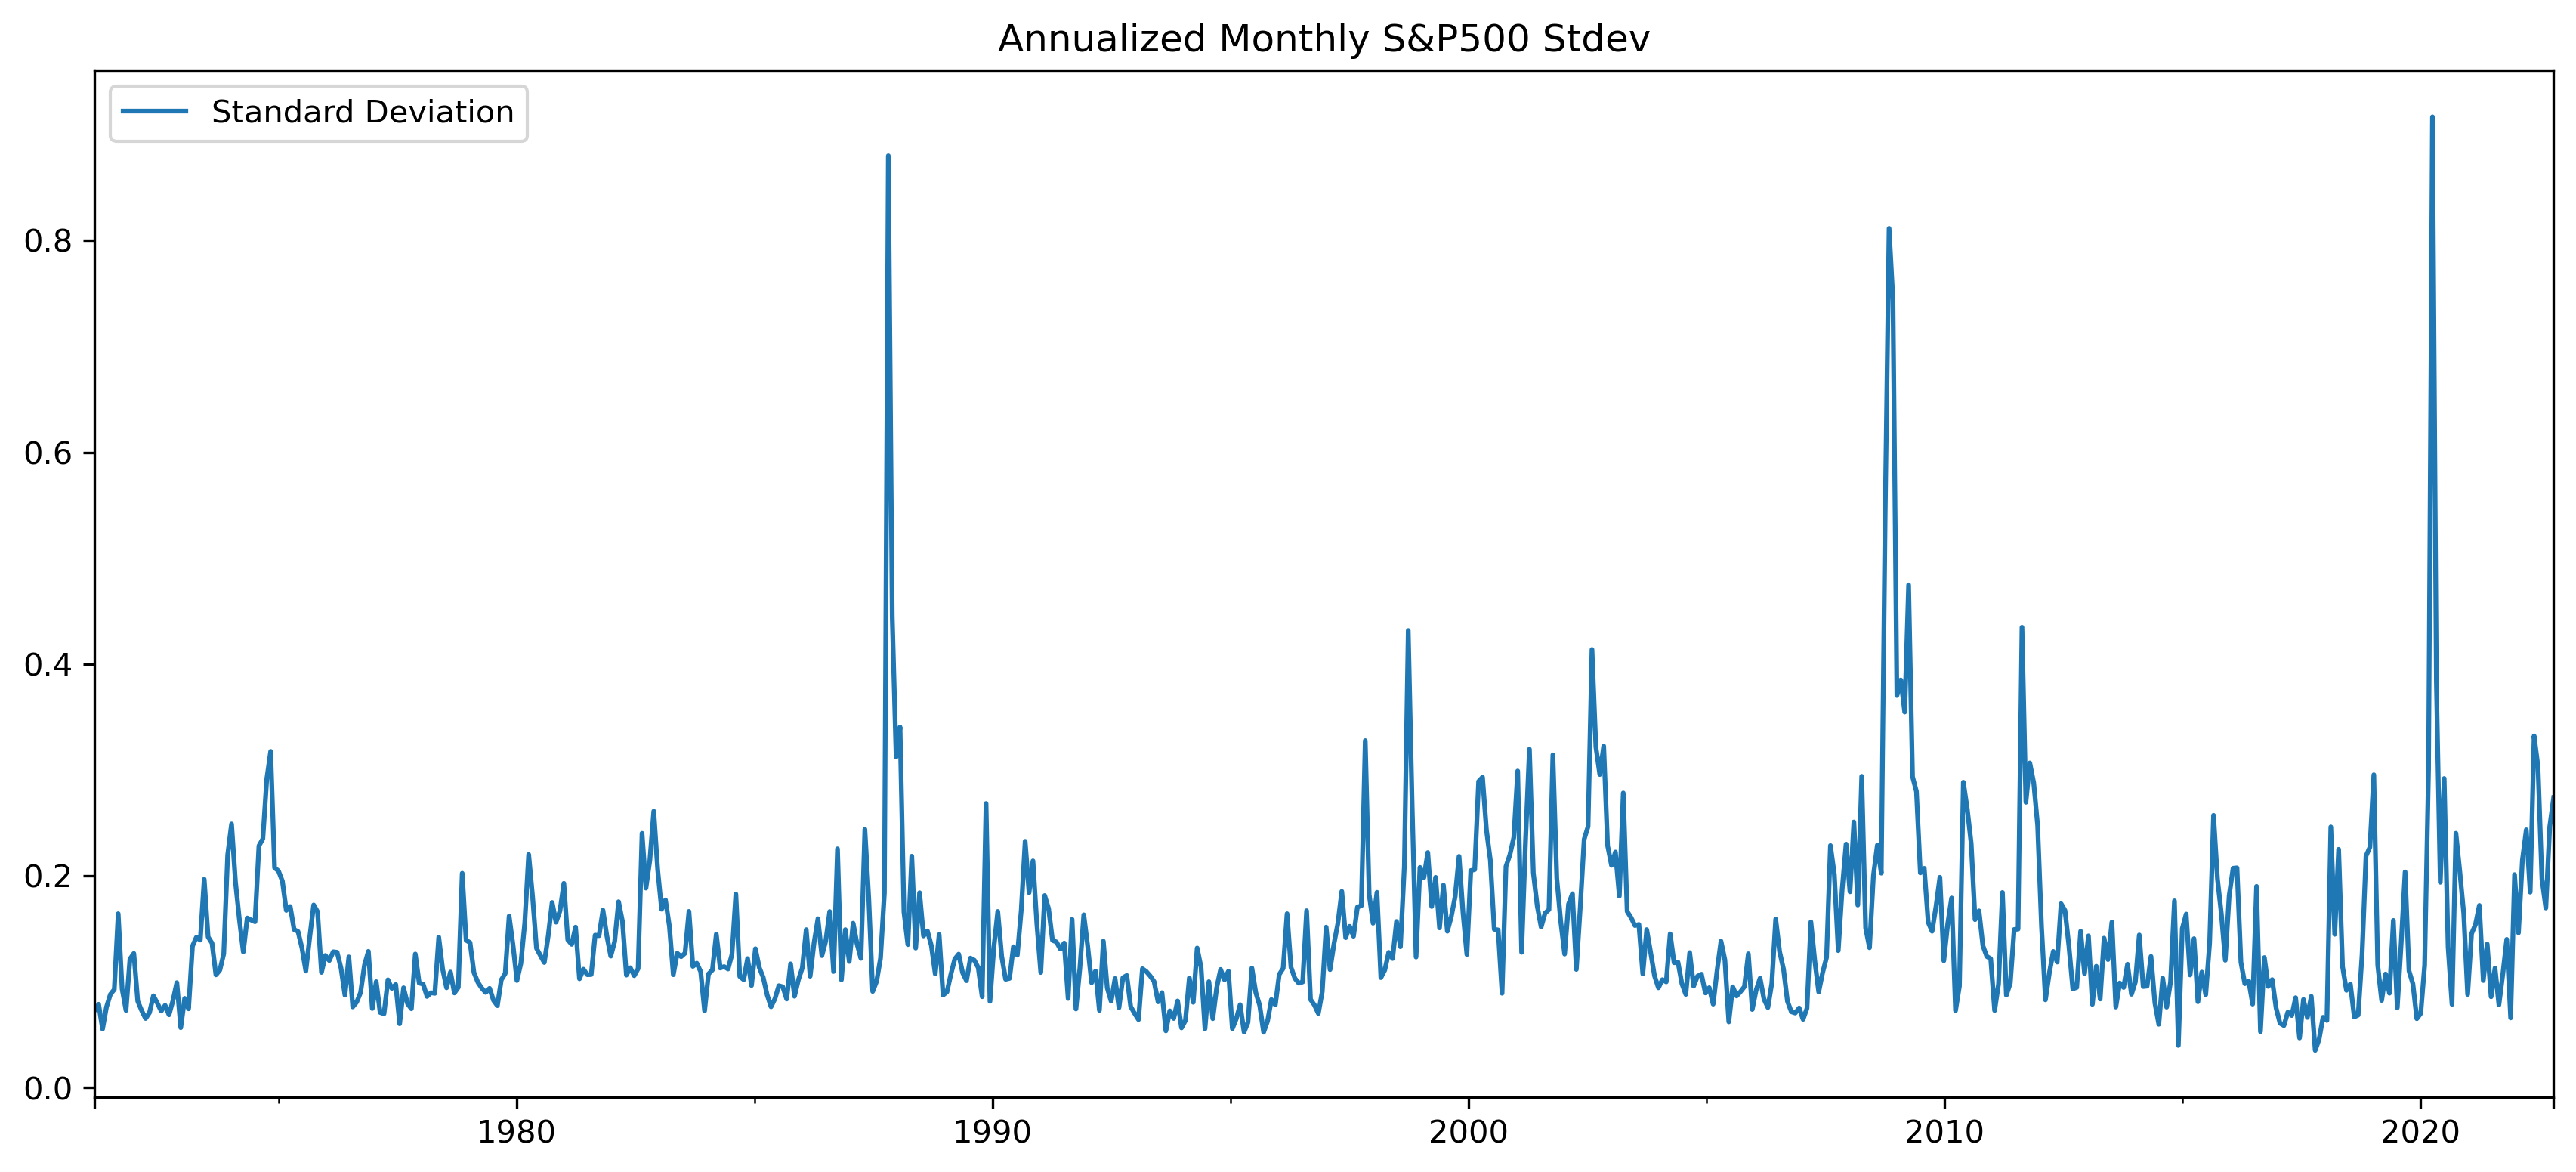

In [31]:
(std_TS(pd.DataFrame(hist), dates)*np.sqrt(253)).plot(title='Annualized Monthly S&P500 Stdev')

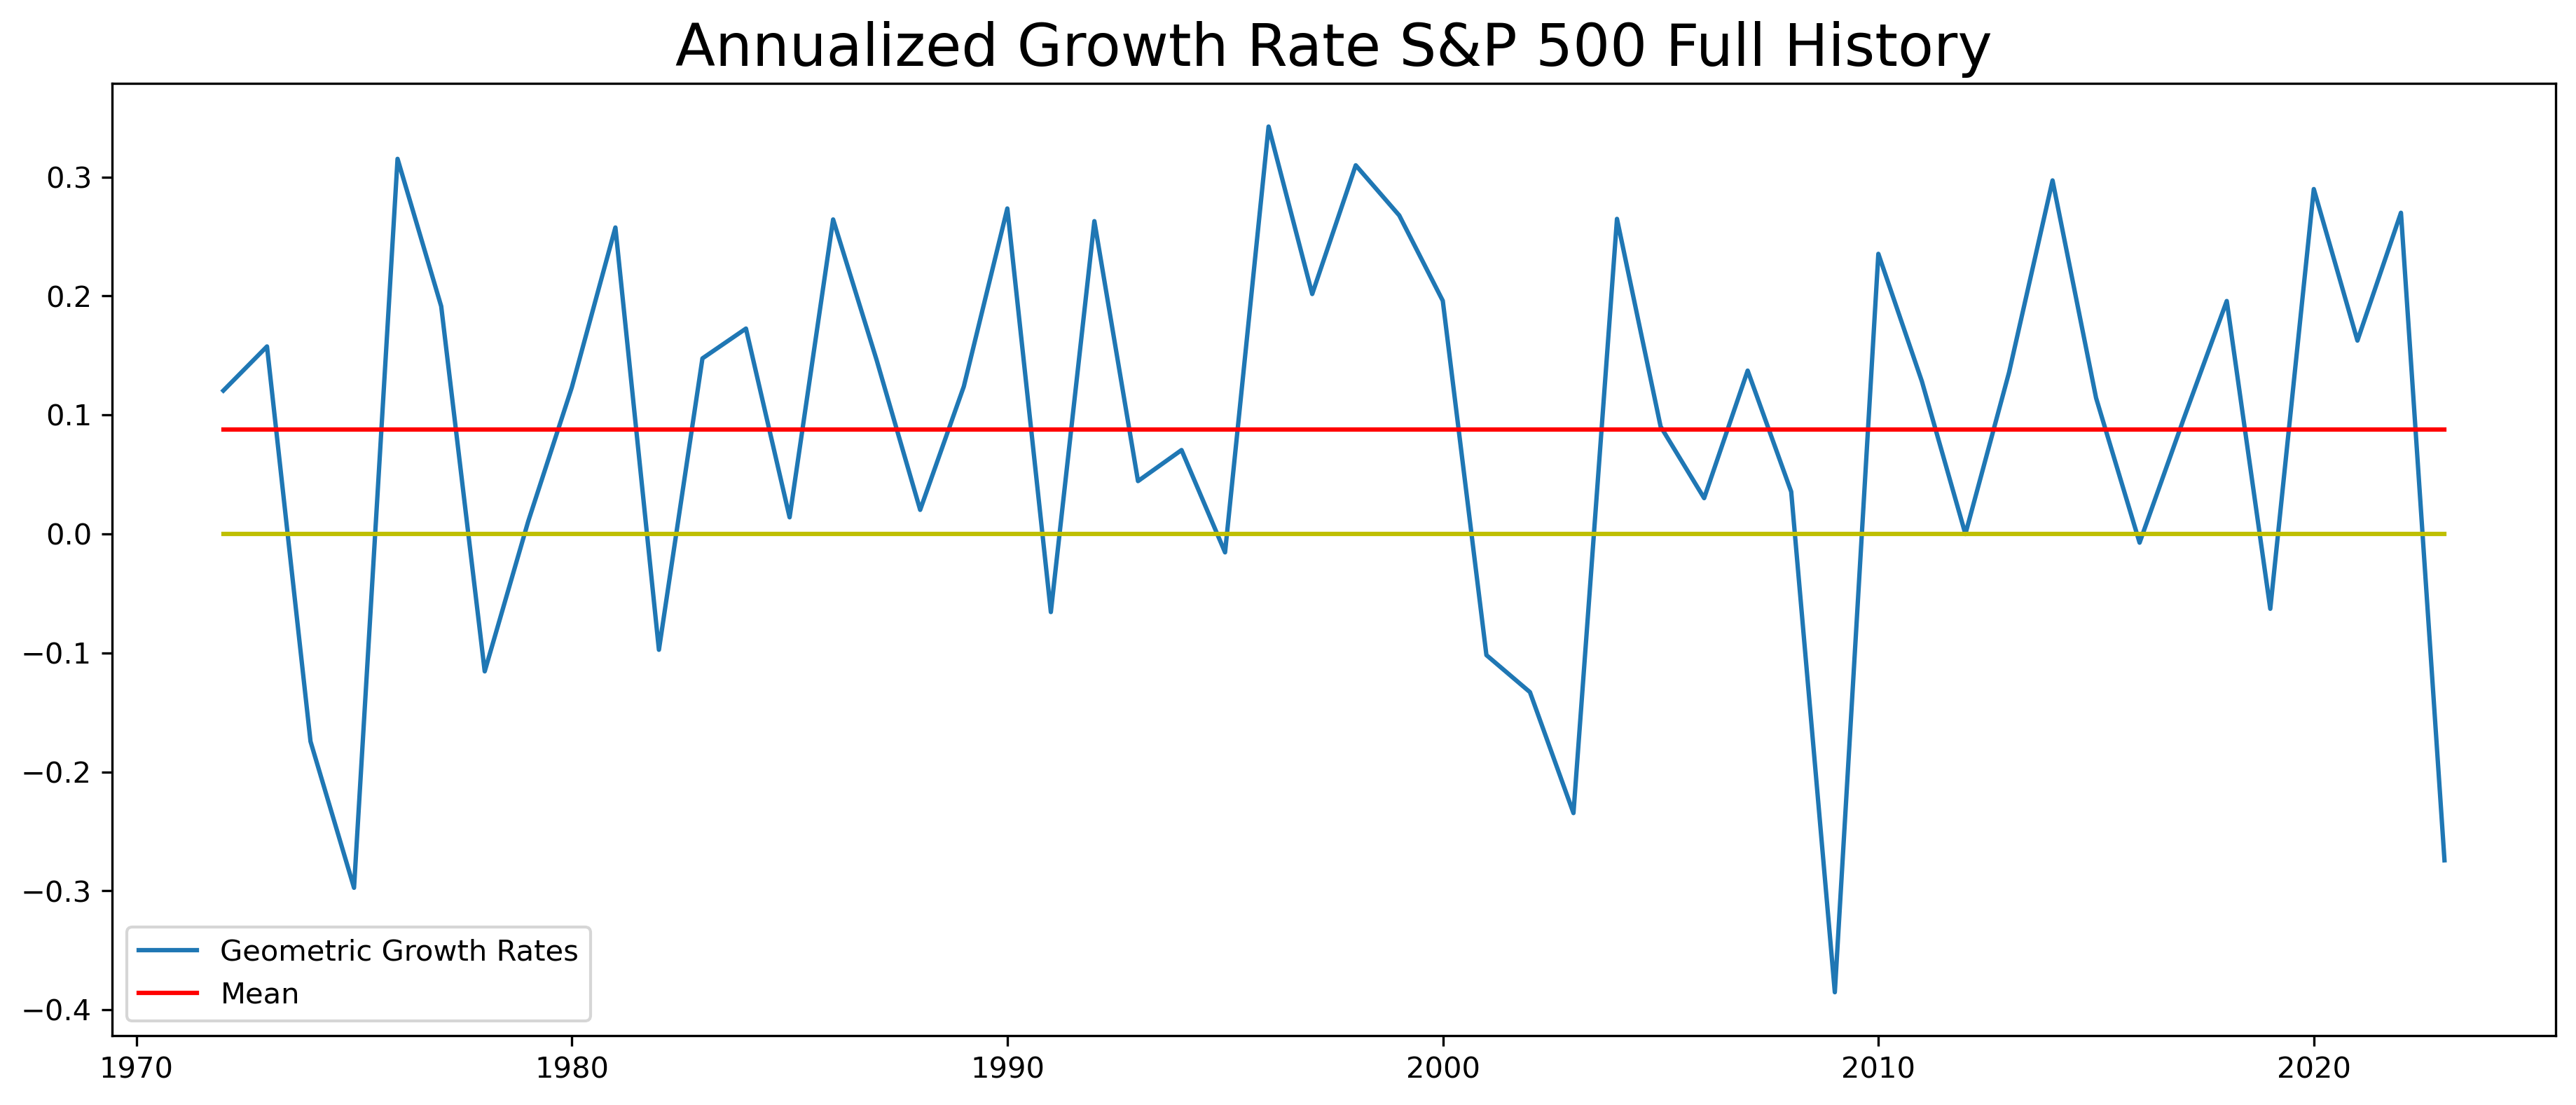

In [32]:
ggr = ((1 + hist.groupby(pd.Grouper(freq='Y')).mean())**253 - 1)
zeros = pd.Series(data = np.zeros(len(ggr)), index=ggr.index)
mean = pd.Series(data = np.ones(len(ggr)) * ggr.mean(), index=ggr.index)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(ggr, label = 'Geometric Growth Rates')
ax.plot (zeros, 'y')
ax.plot (mean, 'r', label = 'Mean')
ax.legend()
plt.title('Annualized Growth Rate S&P 500 Full History', fontsize = 20)
plt.show()

## Testing approaches 

### 1) Starting from today, calculating the premium over the past 5, 10, 15, ... 50 years
### 2) Starting from this year, last year, 2020, 2019, ... 2000, calculating the premium over the past X years
- note, yahoo provides S&P data only after 71. hence if we choose X = 20 years then we can go until 1991 only (1991 - 20 = 1971)

# 1)

In [33]:
starts = [dt.datetime.today() -  dt.timedelta(days = 365 * 5)]

for i in range(10):
    starts.append(starts[i] - dt.timedelta(days = 365 * 5)) 

In [34]:
def method1 (starts):

    rates = []
    since = []
    for i in range(len(starts)-1):
        rates.append(market_RP(get_price('^GSPC', starts[i], end), tnote)[2])
        since.append(starts[i].year)
        
    return pd.DataFrame(rates, index = since, columns = ['Annualized Premium'])

In [35]:
agr1 = method1(starts)
agr1

,Annualized Premium
2017,0.0350
2012,0.0587
2007,0.0203
2002,0.0325
1997,0.0183
1992,0.0344
1987,0.0398
1982,0.0453
1977,0.0445
1972,0.0313


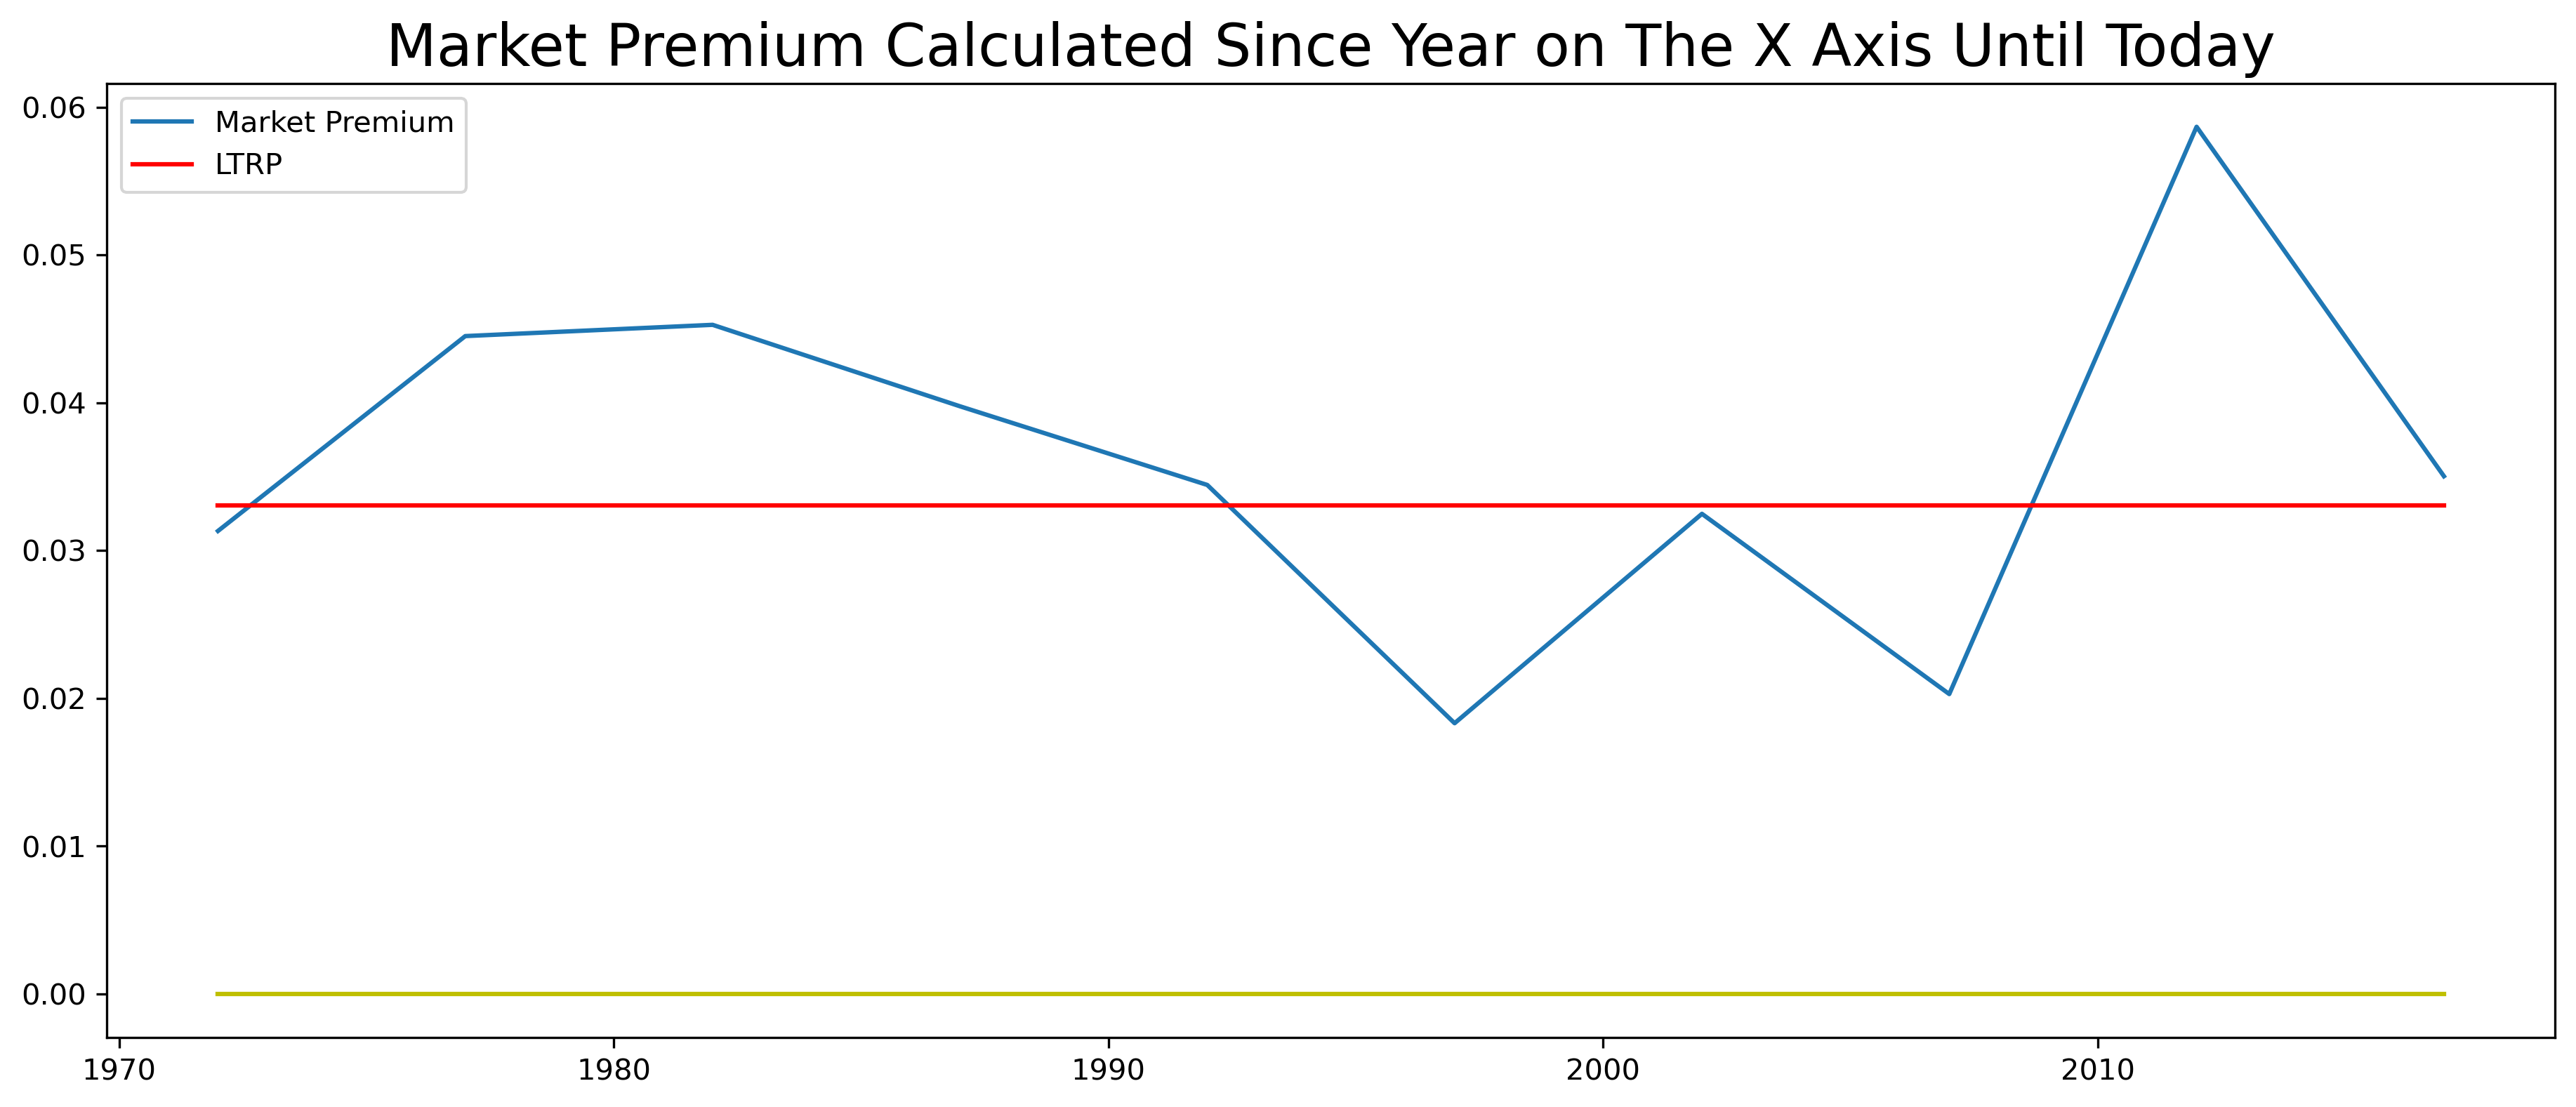

In [36]:
zeros = pd.Series(data = np.zeros(len(agr1)), index=agr1.index)
mean = pd.Series(data = np.ones(len(agr1)) * LTRP, index=agr1.index)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(agr1, label = 'Market Premium')
ax.plot (zeros, 'y')
ax.plot (mean, 'r', label = 'LTRP')
ax.legend()
plt.title('Market Premium Calculated Since Year on The X Axis Until Today', fontsize = 20)
plt.show()

# 2) x=10

In [37]:
ends = [dt.datetime.today()]

for i in range(42):
    ends.append(ends[i] - dt.timedelta(days = 365)) 

In [38]:
dt.datetime(1971, 1, 1) + dt.timedelta(days = 365 * 10) # x=10

datetime.datetime(1980, 12, 29, 0, 0)

In [39]:
def method2():
    rates = []
    since = []
    for i in range(len(ends)-1):
        rates.append(market_RP(get_price('^GSPC', start= ends[i]-dt.timedelta(days = 365 * 10), end=ends[i]), tnote)[2])
        since.append(ends[i].year)
        
    return pd.DataFrame(rates, index = since, columns = ['Annualized Premium'])

In [40]:
agr2 = method2()
agr2

,Annualized Premium
2022,0.0587
2021,0.0968
2020,0.0720
2019,0.0673
2018,0.0773
2017,0.0135
2016,0.0041
2015,0.0142
2014,0.0172
2013,0.0137


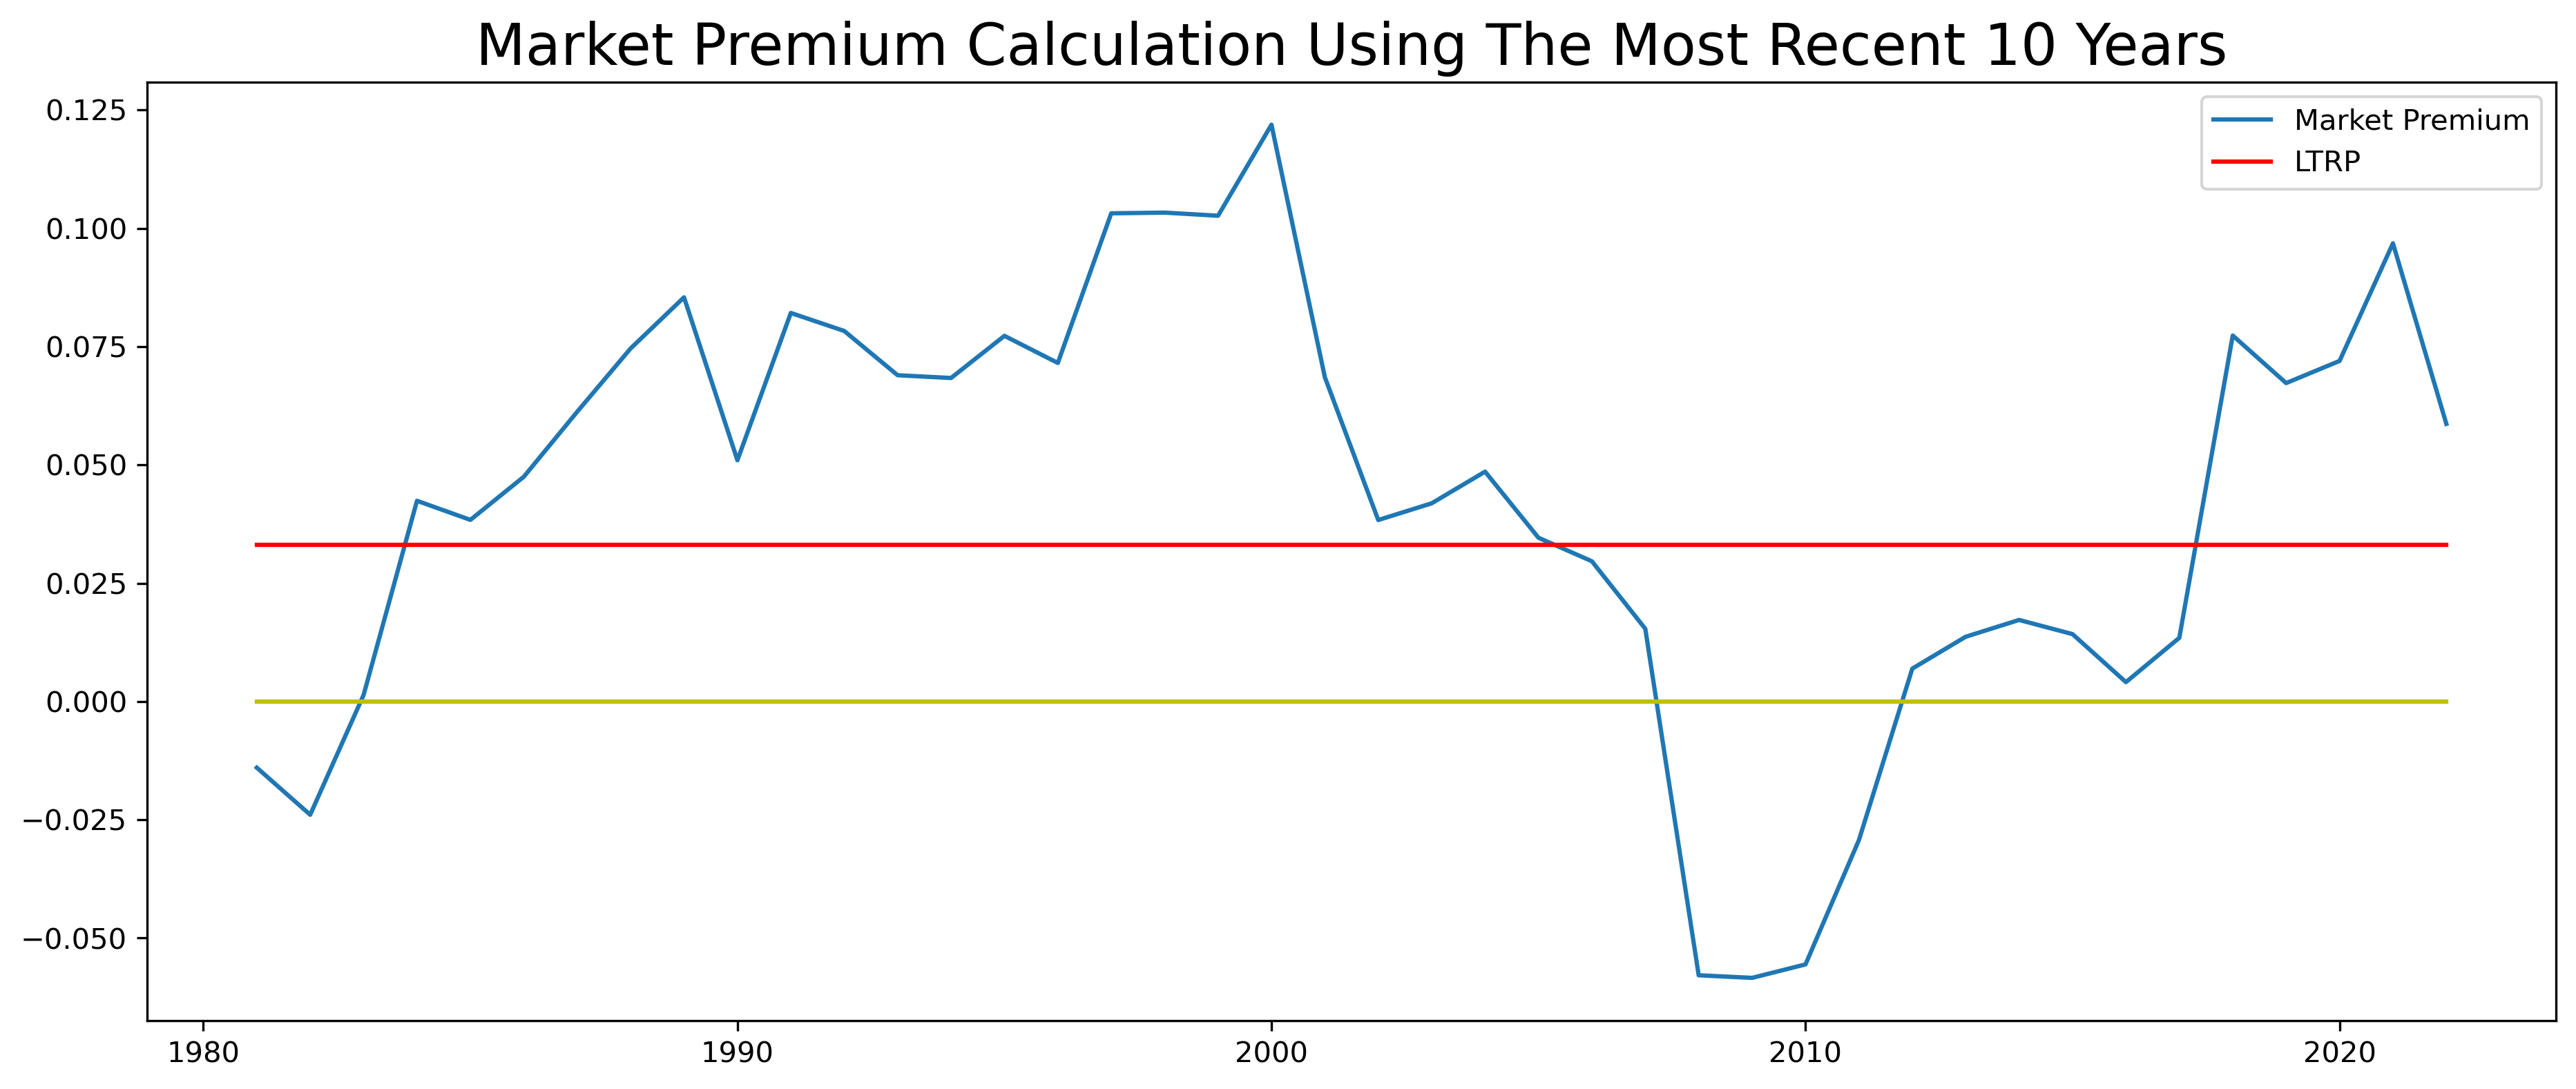

In [41]:
zeros = pd.Series(data = np.zeros(len(agr2)), index=agr2.index)
mean = pd.Series(data = np.ones(len(agr2)) * LTRP, index=agr2.index)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(agr2, label = 'Market Premium')
ax.plot (zeros, 'y')
ax.plot (mean, 'r', label = 'LTRP')
ax.legend()
plt.title('Market Premium Calculation Using The Most Recent 10 Years', fontsize = 20)
plt.show()

# Survey Data

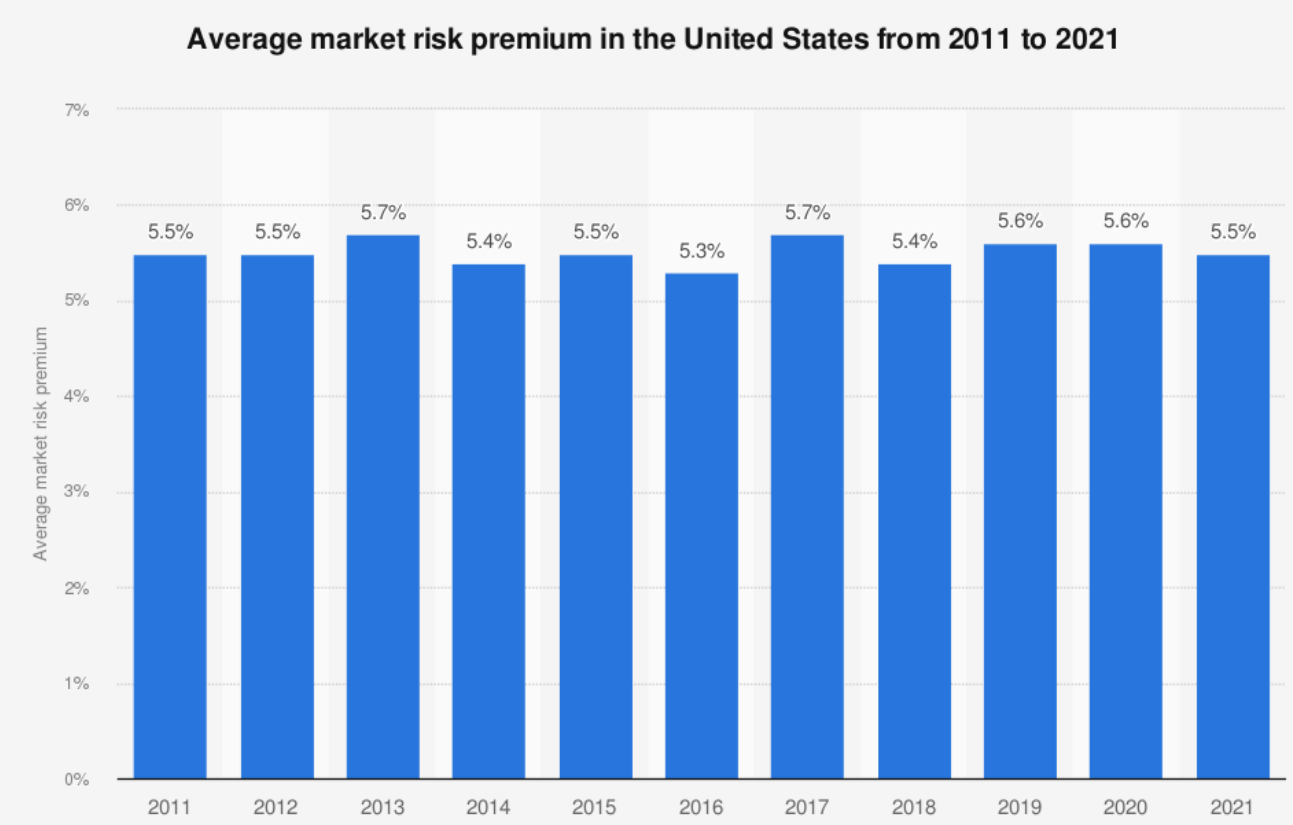

# Conclusion 
- For US stock market use LTRP

# If we use 50 years of stock data does it implies we should use as long as possible time period for crypto assets? 
- Not necessarily. The above discussion suggest that with crypto which is a new asset class we may have to re-consider the length of time used for estimating any of the inputs. Bitcoin only has 10+ years of the price history data over which the public perception of Bitcoin has change significantly. In the first few years it may have been an asset that was attracting only geeks, growing into highly speculative asset to an asset that is being purchased by publicly listed US companies. 
- Prudent approach would be to observe how significantly distribution of returns, standard deviation and other important metrics of an assets have changed with time and hence choose how long time periods we want. 
- Coingecko offers BTC data only from 2013 onwards. The key metric we are focused is the relative standard deviation. Regardless of the period we choose, relative standard deviation is almost constantly in the range 3.5 - 3.8. Therefore, for simplicity we would just use full historical data for any crypto asset. 

In [42]:
btc = cgf.get_BTC_price(start, end)
btc_CCR = (np.log(btc)-np.log(btc.shift(1)))[1:]

In [43]:
summary_stats(pd.DataFrame(hist), btc_CCR, 'sp', 'btc')

C:\Users\amidz\AppData\Local\Temp\ipykernel_9760\159248706.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full = full.append(pd.DataFrame(data=([returns1.skew()[0], returns2.skew()[0]],


,sp,btc,sp/btc
count,13064.0000,3460.0000,0.2648
mean,0.0003,0.0014,5.0500
std,0.0109,0.0411,3.7528
min,-0.2290,-0.4337,1.8940
25%,-0.0046,-0.0139,3.0164
50%,0.0005,0.0020,4.1088
75%,0.0056,0.0186,3.3402
max,0.1096,0.2871,2.6202
Skew,-1.0226,-0.5168,0.5054
Kurtosis,24.1622,8.3302,0.3448


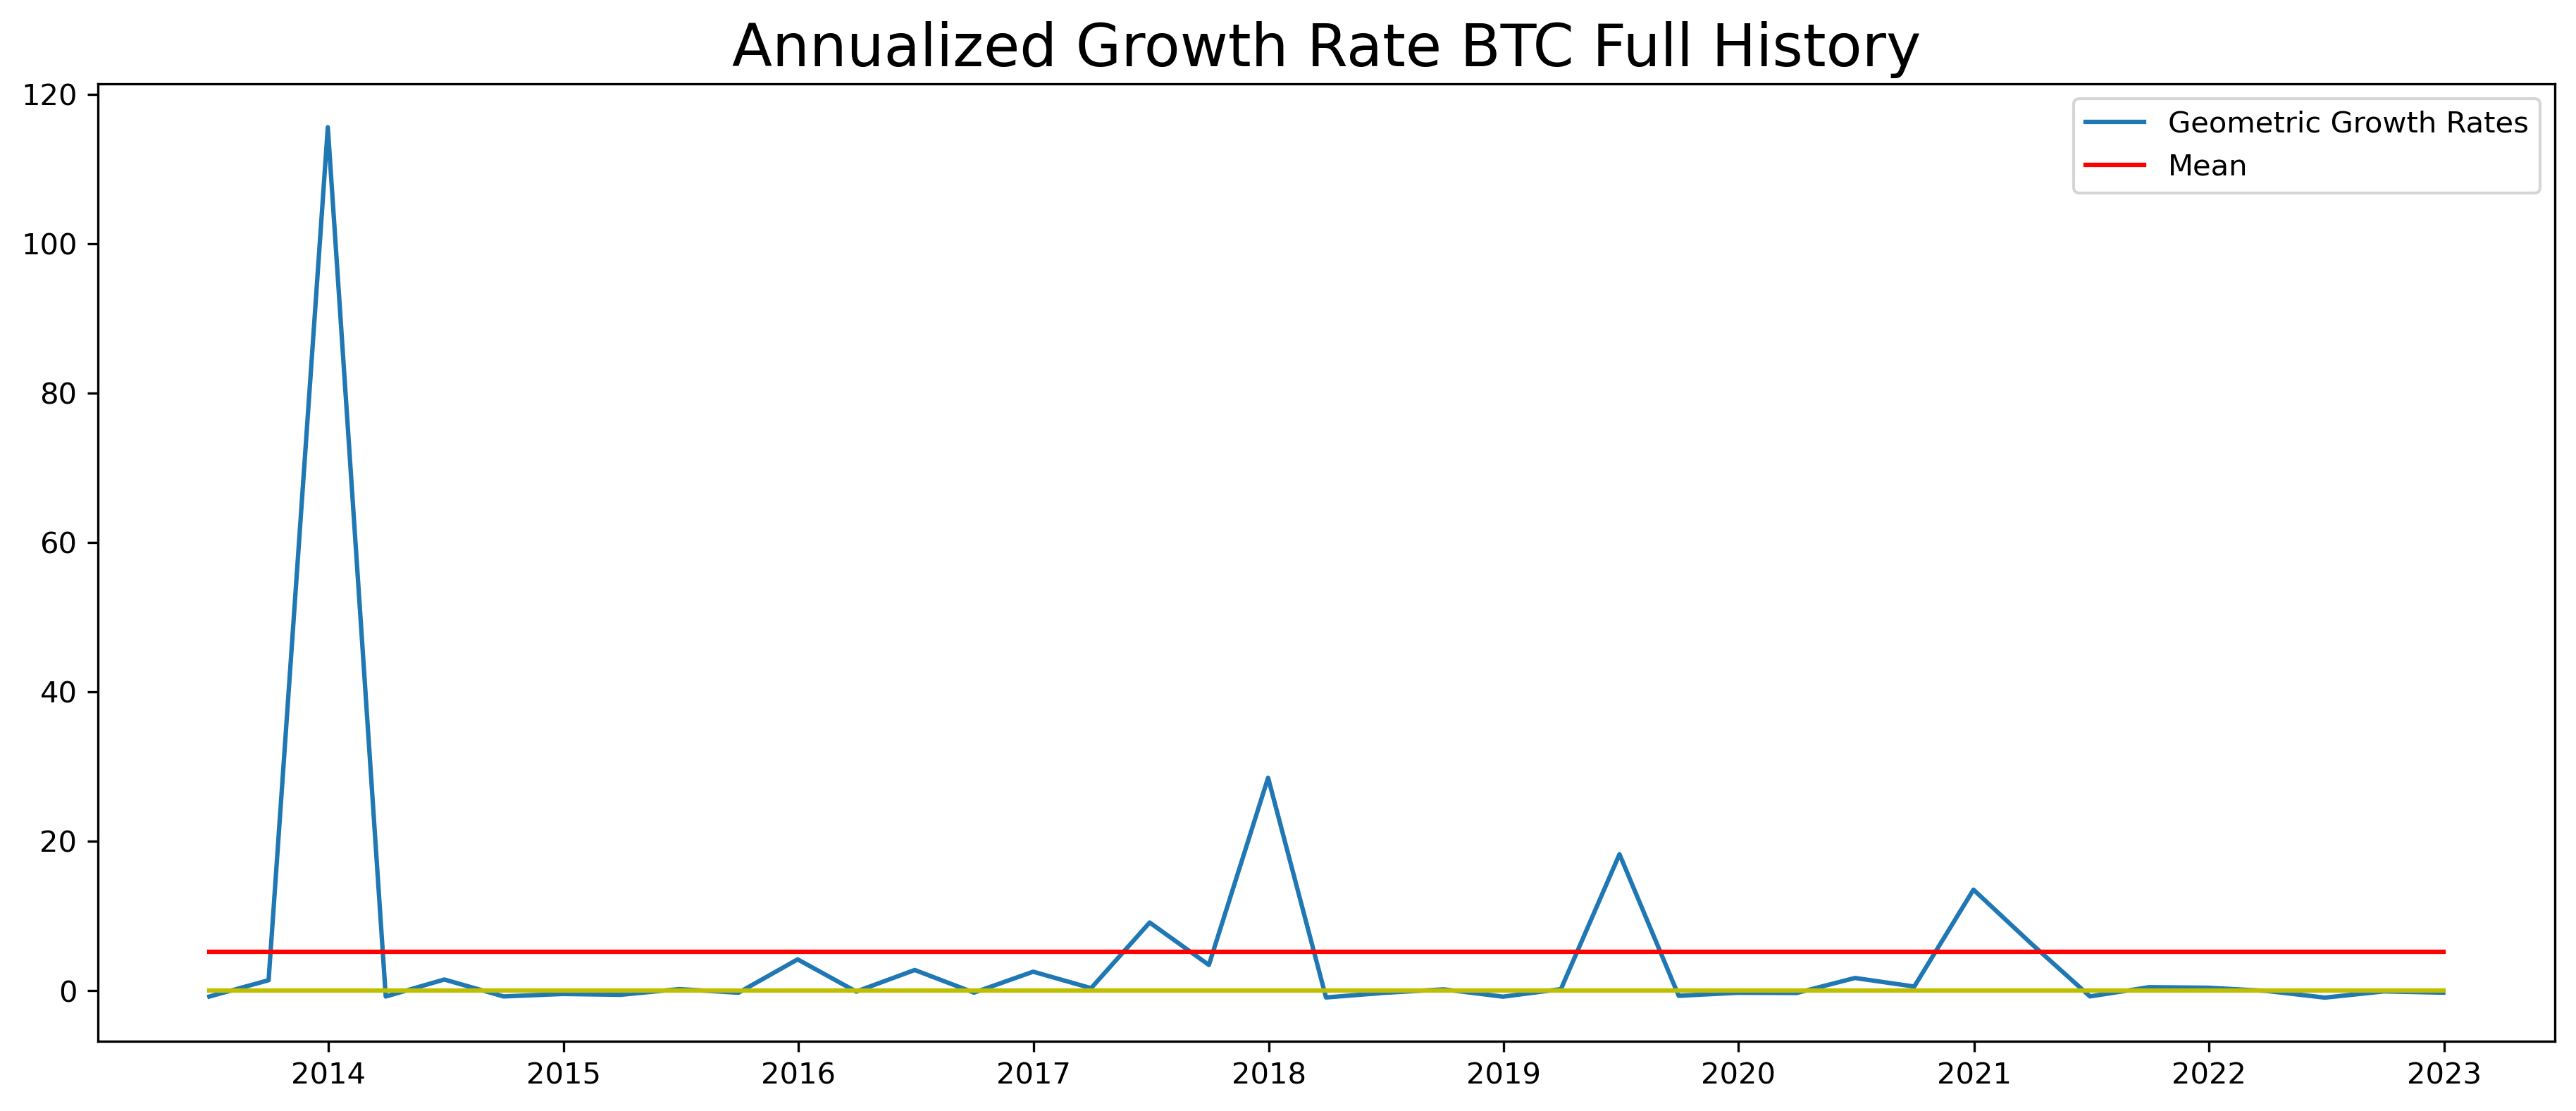

In [44]:
bggr = ((1 + btc_CCR.groupby(pd.Grouper(freq='Q')).mean())**253 - 1)
zeros = pd.Series(data = np.zeros(len(bggr)), index=bggr.index)
mean = pd.Series(data = np.ones(len(bggr)) * bggr.mean()[0], index=bggr.index)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(bggr, label = 'Geometric Growth Rates')
ax.plot (zeros, 'y')
ax.plot (mean, 'r', label = 'Mean')
ax.legend()
plt.title('Annualized Growth Rate BTC Full History', fontsize = 20)
plt.show()

In [45]:
dates = intervals(30, start = btc_CCR.index[0])

## Standard Deviation Time Series

<AxesSubplot:title={'center':'Annualized Monthly BTC Stdev'}>

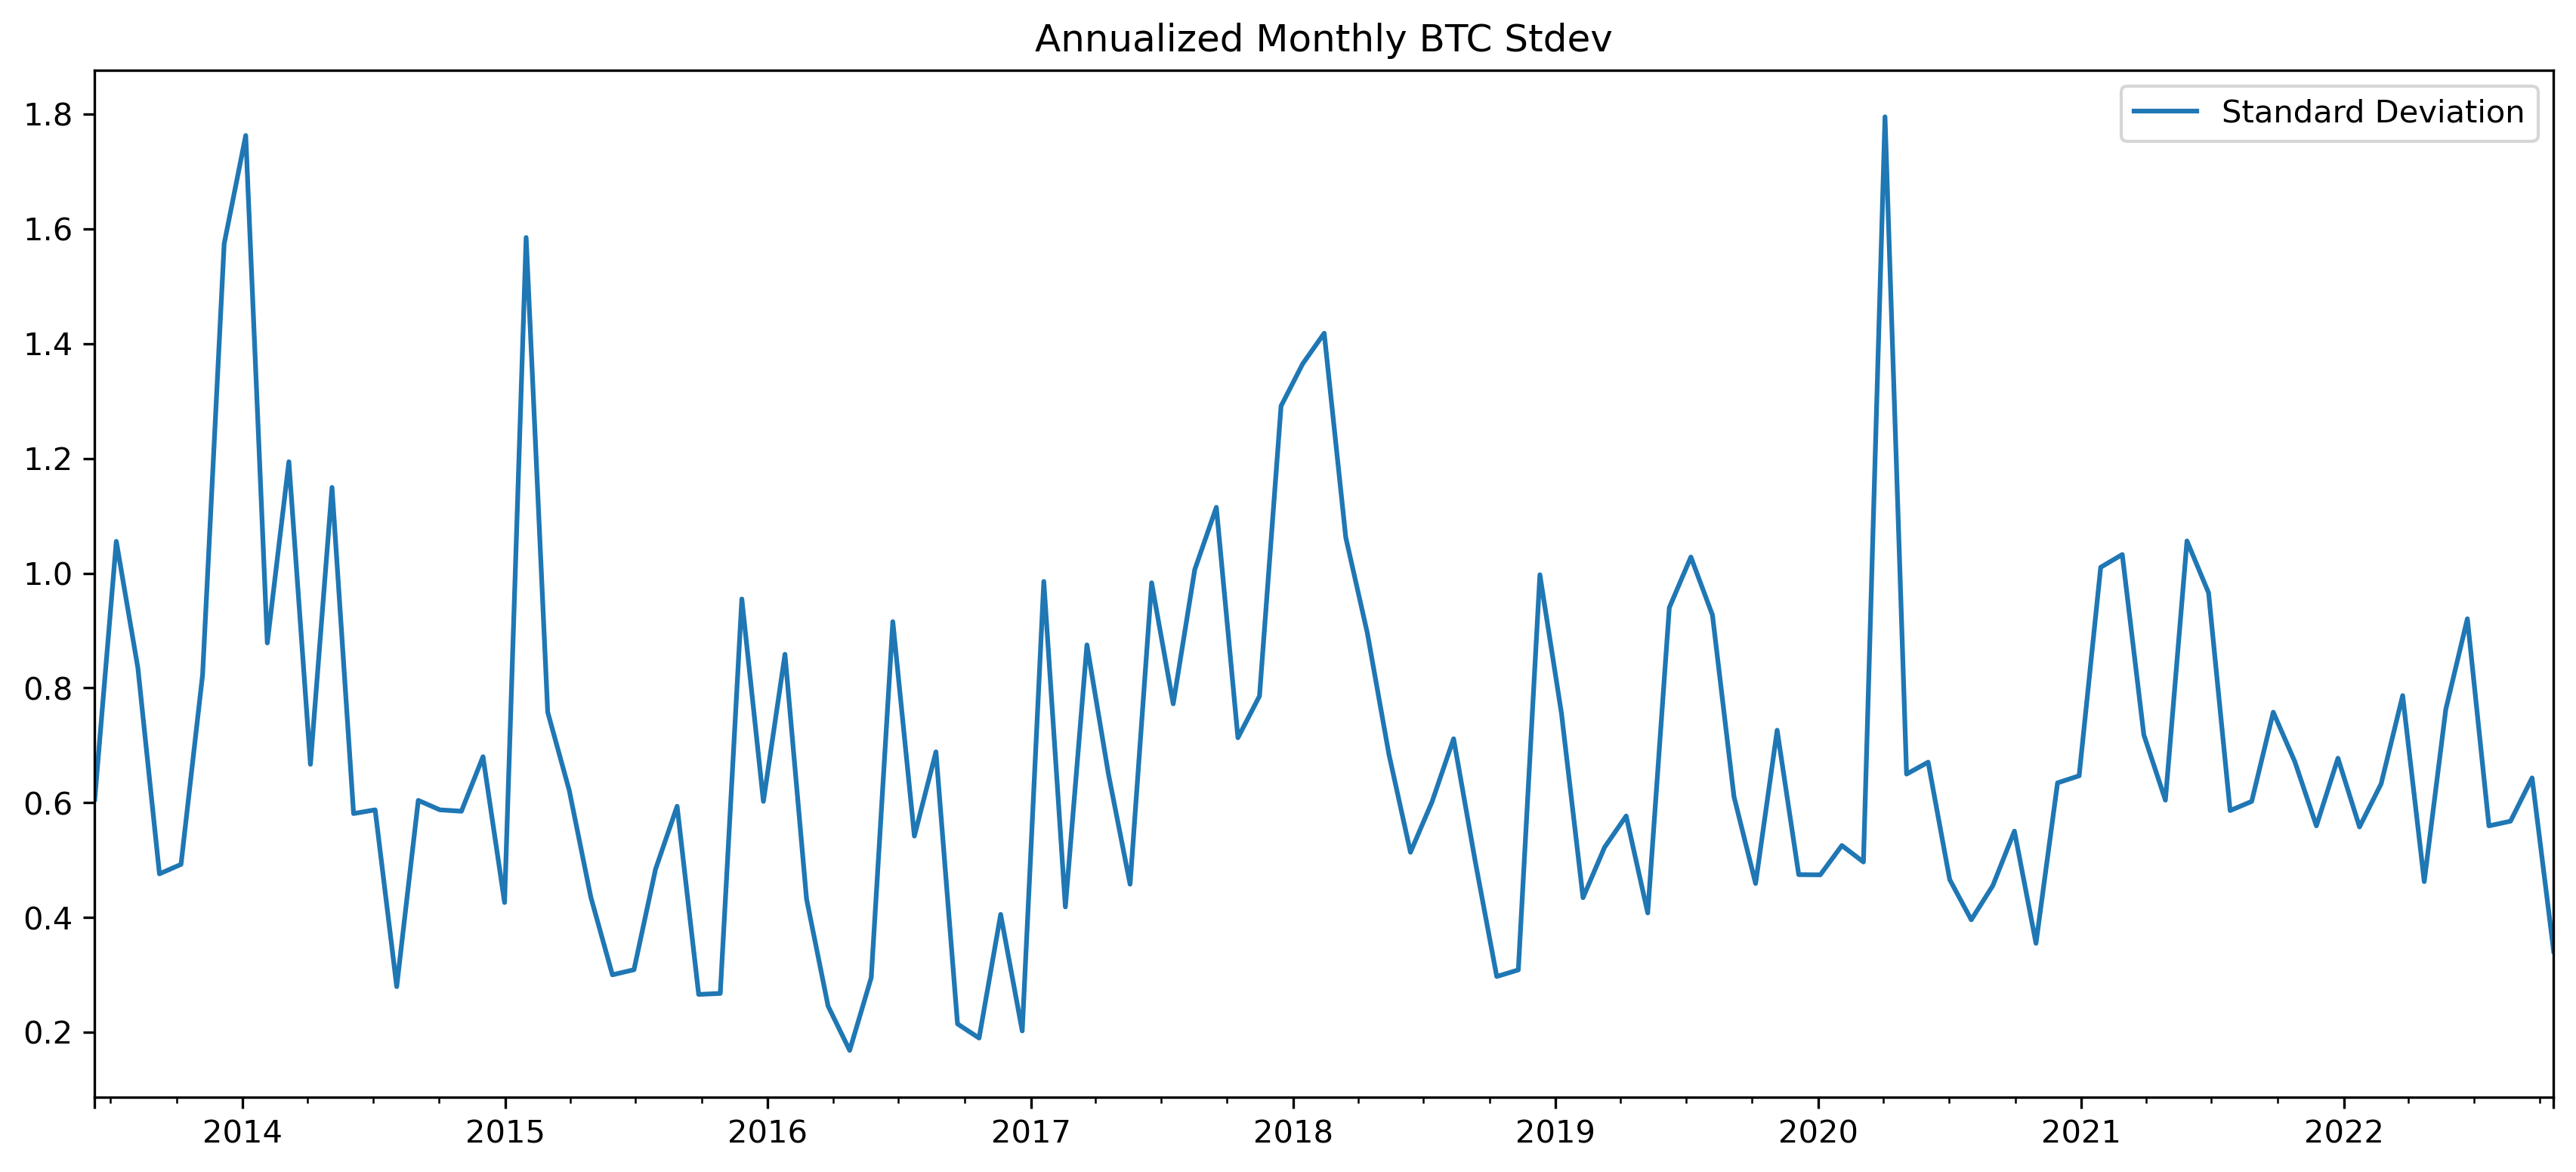

In [46]:
(std_TS(btc_CCR, dates)*np.sqrt(365)).plot(title = 'Annualized Monthly BTC Stdev')

In [47]:
def log_returns(prices):
    
    return (np.log(prices)-np.log(prices.shift(1)))[1:]

# According to our methodology, crypto asset risk premiums should be:

In [65]:
coins = ['ethereum', 'uniswap', 'dydx', 'gmx', 'havven', 'perpetual-protocol']

In [49]:
prices = {}
returns = {}
stdev = []
risk_premium = []

In [63]:
def get_discount_rate (token, LTRP = LTRP, hist = hist, start = dt.datetime(2013, 1, 1), end = dt.datetime.today()):
    price = cgf.get_data_start_to_end(token, start, end)
    returns = log_returns(price)
    stdev = np.std(returns)
    
    return print("Discount rate for {0} is".format(token), round((tnote + LTRP * stdev / np.std(hist))[0] * 100, 2), "%.", 
                 "\nRisk free rate is", round(tnote*100, 2), "%",
                 "\nDaily standard deviation for {0} is".format(token), round(stdev[0]*100, 2), "%.",
                 "\nLong term risk premium is", round(LTRP*100, 2), "%.", 
                "\nS&P500 daily standard deviation is", round(np.std(hist)*100, 2), "%.")

In [64]:
get_discount_rate('uniswap')

Discount rate for uniswap is 26.71 %. 
Risk free rate is 4.13 % 
Daily standard deviation for uniswap is 7.48 %. 
Long term risk premium is 3.31 %. 
S&P500 daily standard deviation is 1.09 %.


In [66]:
for i in range(len(coins)):
    prices[i] = cgf.get_data_start_to_end(coins[i], dt.datetime(2013, 1, 1), dt.datetime.today())
    returns[i] = log_returns(prices[i])
    stdev.append(np.std(returns[i])[0])
    risk_premium.append(LTRP * np.std(returns[i])[0] / np.std(hist))


stdev_ = pd.DataFrame(stdev, index = coins, columns=['Stdev'])
stdev_ = stdev_.sort_values(by=['Stdev'])
    
    
discount_rates = pd.DataFrame(tnote+ risk_premium, index = coins, columns=['Discount Rate'])
discount_rates = discount_rates.sort_values(by=['Discount Rate'])

discount_rates

,Discount Rate
ethereum,0.2299
dydx,0.2670
uniswap,0.2671
perpetual-protocol,0.2851
havven,0.2896
gmx,0.3196


In [67]:
discount_rates

,Discount Rate
ethereum,0.2299
dydx,0.2670
uniswap,0.2671
perpetual-protocol,0.2851
havven,0.2896
gmx,0.3196
